# Les librairies


In [31]:
# import des librairies
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import joblib
import livelossplot
import random
import shutil

from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img #data augmentation

# Dataset MMU-Iris-Database à modifier pour oeil gauche et droit
### Séparation et data augmentation à réaliser uniquement la première fois, sur le premier notebook utilisé, car identique aux 3

## Séparation du dataset en 'TRAIN', 'VALID' & 'TEST' pour oeil gauche et droit

#### Tirage aléatoire pour création du dossier 'test'

In [ ]:
# Chemin vers le dossier principal
MMU_Iris_Database = 'MMU-Iris-Database'

# Création du dossier de test
dossier_test = os.path.join(MMU_Iris_Database, 'test')
os.makedirs(dossier_test, exist_ok=True)

# Parcourir les dossiers numérotés
for num_dossier in range(1, 47):
    if num_dossier != 4:  # Ignorer le dossier manquant
        dossier_num = os.path.join(MMU_Iris_Database, str(num_dossier))
        dossier_droit = os.path.join(dossier_num, 'right')
        dossier_gauche = os.path.join(dossier_num, 'left')

        images_droit = os.listdir(dossier_droit)
        images_gauche = os.listdir(dossier_gauche)

        # Tirage aléatoire d'une image pour chaque côté
        image_droit_choisie = random.choice(images_droit)
        image_gauche_choisie = random.choice(images_gauche)

        # Chemins complets des images choisies
        chemin_image_droit = os.path.join(dossier_droit, image_droit_choisie)
        chemin_image_gauche = os.path.join(dossier_gauche, image_gauche_choisie)

        # Création des dossiers dans le dossier de test
        dossier_test_num = os.path.join(dossier_test, str(num_dossier))
        os.makedirs(os.path.join(dossier_test_num, 'right'), exist_ok=True)
        os.makedirs(os.path.join(dossier_test_num, 'left'), exist_ok=True)

        # Chemins complets pour copier les images dans le dossier de test
        chemin_image_droit_test = os.path.join(dossier_test_num, 'right', image_droit_choisie)
        chemin_image_gauche_test = os.path.join(dossier_test_num, 'left', image_gauche_choisie)

        # Copie des images choisies dans le dossier de test
        shutil.copy(chemin_image_droit, chemin_image_droit_test)
        shutil.copy(chemin_image_gauche, chemin_image_gauche_test)

        # Suppression des images originales
        os.remove(chemin_image_droit)
        os.remove(chemin_image_gauche)


FileNotFoundError: ignored

#### Tirage aléatoire pour création du dossier 'valid'

In [ ]:
# Chemin vers le dossier principal
MMU_Iris_Database = 'MMU-Iris-Database'

# Création du dossier de validation
dossier_valid = os.path.join(MMU_Iris_Database, 'valid')
os.makedirs(dossier_valid, exist_ok=True)

# Parcourir les dossiers numérotés
for num_dossier in range(1, 47):
    if num_dossier != 4:  # Ignorer le dossier manquant
        dossier_num = os.path.join(MMU_Iris_Database, str(num_dossier))
        dossier_droit = os.path.join(dossier_num, 'right')
        dossier_gauche = os.path.join(dossier_num, 'left')

        images_droit = os.listdir(dossier_droit)
        images_gauche = os.listdir(dossier_gauche)

        # Tirage aléatoire d'une image pour chaque côté
        image_droit_choisie = random.choice(images_droit)
        image_gauche_choisie = random.choice(images_gauche)

        # Chemins complets des images choisies
        chemin_image_droit = os.path.join(dossier_droit, image_droit_choisie)
        chemin_image_gauche = os.path.join(dossier_gauche, image_gauche_choisie)

        # Création des dossiers dans le dossier de valid
        dossier_valid_num = os.path.join(dossier_valid, str(num_dossier))
        os.makedirs(os.path.join(dossier_valid_num, 'right'), exist_ok=True)
        os.makedirs(os.path.join(dossier_valid_num, 'left'), exist_ok=True)

        # Chemins complets pour copier les images dans le dossier de test
        chemin_image_droit_valid = os.path.join(dossier_valid_num, 'right', image_droit_choisie)
        chemin_image_gauche_valid = os.path.join(dossier_valid_num, 'left', image_gauche_choisie)

        # Copie des images choisies dans le dossier de test
        shutil.copy(chemin_image_droit, chemin_image_droit_valid)
        shutil.copy(chemin_image_gauche, chemin_image_gauche_valid)

        # Suppression des images originales
        os.remove(chemin_image_droit)
        os.remove(chemin_image_gauche)

#### Regrouper les dossiers numérotés restants dans le dossier 'train'

In [ ]:
# Chemin vers le dossier principal
MMU_Iris_Database = 'MMU-Iris-Database'

# Chemin vers le dossier 'train'
dossier_train = os.path.join(MMU_Iris_Database, 'train')
os.makedirs(dossier_train, exist_ok=True)

# Déplacement des dossiers numérotés vers le dossier 'train'
for num_dossier in range(1, 47):
    if num_dossier != 4:  # Ignorer le dossier manquant '4'
        dossier_num = os.path.join(MMU_Iris_Database, str(num_dossier))
        shutil.move(dossier_num, dossier_train)

## Data augmentation pour entrainement des modèles pour oeil gauche et droit
(Ne lancer qu'une seule fois sur le dossier 'train', 'valid' et 'test')

#### Data augmentation pour le 'train'

In [ ]:
# chemins vers dossier
input_dir = 'MMU-Iris-Database/train'

# générateur d'image augmentée
datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],  # ajuster la plage de la luminosité
    width_shift_range=0.1,  # ajuster la plage du décalage horizontal
    height_shift_range=0.1, # ajuster la plage du décalage horizontal
    fill_mode='nearest'
)

# boucle pour parcourir chaque image et sauvegarder la nouvelle image
for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        for sous_dossier in os.listdir(folder_path):
            sous_dossier_path = os.path.join(folder_path, sous_dossier)
            if os.path.isdir(sous_dossier_path):
                for image_name in os.listdir(sous_dossier_path):
                    if image_name.endswith('.bmp'):
                        image_path = os.path.join(sous_dossier_path, image_name)
                        img = load_img(image_path)
                        x = img_to_array(img)
                        x = x.reshape((1,) + x.shape)

                        i = 0
                        for batch in datagen.flow(x, batch_size=1, save_to_dir=sous_dossier_path, save_prefix=image_name.split('.')[0], save_format='bmp'):
                            i += 1
                            if i >= 5:  # Une seule copie zoomée par image
                                break

#### Data augmentation pour le 'valid'

In [ ]:
# chemins vers dossier
input_dir = 'MMU-Iris-Database/valid'

# générateur d'image augmentée
datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],  # ajuster la plage de la luminosité
    width_shift_range=0.1,  # ajuster la plage du décalage horizontal
    height_shift_range=0.1, # ajuster la plage du décalage horizontal
    fill_mode='nearest'
)

# boucle pour parcourir chaque image et sauvegarder la nouvelle image
for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        for sous_dossier in os.listdir(folder_path):
            sous_dossier_path = os.path.join(folder_path, sous_dossier)
            if os.path.isdir(sous_dossier_path):
                for image_name in os.listdir(sous_dossier_path):
                    if image_name.endswith('.bmp'):
                        image_path = os.path.join(sous_dossier_path, image_name)
                        img = load_img(image_path)
                        x = img_to_array(img)
                        x = x.reshape((1,) + x.shape)

                        i = 0
                        for batch in datagen.flow(x, batch_size=1, save_to_dir=sous_dossier_path, save_prefix=image_name.split('.')[0], save_format='bmp'):
                            i += 1
                            if i >= 5:  # Une seule copie zoomée par image
                                break

#### Data augmentation pour le 'test'

In [ ]:
# chemins vers dossier
input_dir = 'MMU-Iris-Database/test'

# générateur d'image augmentée (zoom)
datagen = ImageDataGenerator(
    brightness_range=[0.4, 0.9],  # ajuster la plage de la luminosité
    width_shift_range=0.1,  # ajuster la plage du décalage horizontal
    height_shift_range=0.1, # ajuster la plage du décalage horizontal
    fill_mode='nearest'
)

# boucle pour parcourir chaque image et sauvegarder la nouvelle image
for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        for sous_dossier in os.listdir(folder_path):
            sous_dossier_path = os.path.join(folder_path, sous_dossier)
            if os.path.isdir(sous_dossier_path):
                for image_name in os.listdir(sous_dossier_path):
                    if image_name.endswith('.bmp'):
                        image_path = os.path.join(sous_dossier_path, image_name)
                        img = load_img(image_path)
                        x = img_to_array(img)
                        x = x.reshape((1,) + x.shape)

                        i = 0
                        for batch in datagen.flow(x, batch_size=1, save_to_dir=sous_dossier_path, save_prefix=image_name.split('.')[0], save_format='bmp'):
                            i += 1
                            if i >= 5:  # Une seule copie zoomée par image
                                break

## Les fonctions

In [32]:
## Prétraitement de l'image : redimensionnemennt et standardization
def preprocess_img(img,new_dim=(240,320)):
    new_img=cv2.resize(img, (new_dim[1],new_dim[0]), interpolation = cv2.INTER_AREA)
    # Normalisation en divisant par 255
    last_img = new_img / 255.0
    return last_img

## Récupération des images

In [33]:
# Chemin vers les dossier principaux 'train', 'valid' & 'test' contenant les sous-dossiers
main_folder_train = 'MMU-Iris-Database/train'
img_dim=(240,320,3)

main_folder_test = 'MMU-Iris-Database/test'
img_dim=(240,320,3)

main_folder_valid = 'MMU-Iris-Database/valid'
img_dim=(240,320,3)

## Préparation de la dataset

#### Oeil droit ou oeil gauche ?

In [34]:
# TRAIN
X_train = []
Y_train = []

for target_folder in os.listdir(main_folder_train):
    target_path = os.path.join(main_folder_train, target_folder)

    if os.path.isdir(target_path):
        for side in ['left', 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        image = preprocess_img(cv2.imread(image_path), img_dim)

                        # Stocker les images dans X
                        X_train.append(image)

                        # Stocker la cible 'left' ou 'right' dans Y
                        Y_train.append(side)

In [35]:
# VALID
X_valid = []
Y_valid = []

for target_folder in os.listdir(main_folder_valid):
    target_path = os.path.join(main_folder_valid, target_folder)

    if os.path.isdir(target_path):
        for side in ['left', 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        image = preprocess_img(cv2.imread(image_path), img_dim)

                        # Stocker les images dans X
                        X_valid.append(image)

                        # Stocker la cible 'left' ou 'right' dans Y
                        Y_valid.append(side)

In [36]:
# TEST
X_test = []
Y_test = []

for target_folder in os.listdir(main_folder_test):
    target_path = os.path.join(main_folder_test, target_folder)

    if os.path.isdir(target_path):
        for side in ['left', 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        image = preprocess_img(cv2.imread(image_path), img_dim)

                        # Stocker les images dans X
                        X_test.append(image)

                        # Stocker la cible 'left' ou 'right' dans Y
                        Y_test.append(side)

In [37]:
# Nb images dans chaque variables
print(len(X_train), len(Y_train))
print(len(X_valid), len(Y_valid))
print(len(X_test), len(Y_test))

1620 1620
540 540
539 539


In [38]:
# TRAIN
pd.Series(Y_train).value_counts()

left     810
right    810
dtype: int64

In [39]:
# VALID
pd.Series(Y_valid).value_counts()

left     270
right    270
dtype: int64

In [40]:
# TEST
pd.Series(Y_test).value_counts()

right    270
left     269
dtype: int64

## Encodage

#### Classifier pour déterminer oeil gauche ou droite

In [43]:
# TRAIN
labelEnc_class=preprocessing.LabelEncoder()
Y_enc_train=labelEnc_class.fit_transform(Y_train)

In [46]:
# VALID
labelEnc_class=preprocessing.LabelEncoder()
Y_enc_valid=labelEnc_class.fit_transform(Y_valid)

In [47]:
# TEST
labelEnc_class=preprocessing.LabelEncoder()
Y_enc_test=labelEnc_class.fit_transform(Y_test)

In [ ]:
# Sauvegarde de l'encodeur
joblib.dump(labelEnc_class, 'joblib/encodeur/encodeur_classifier.joblib')

['/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/joblib/encodeur/encodeur_classifier.joblib']

#### Categorical pour dataset base

In [49]:
# categorical
y_train_enc=to_categorical(Y_enc_train)
y_test_enc=to_categorical(Y_enc_test)
y_valid_enc=to_categorical(Y_enc_valid)

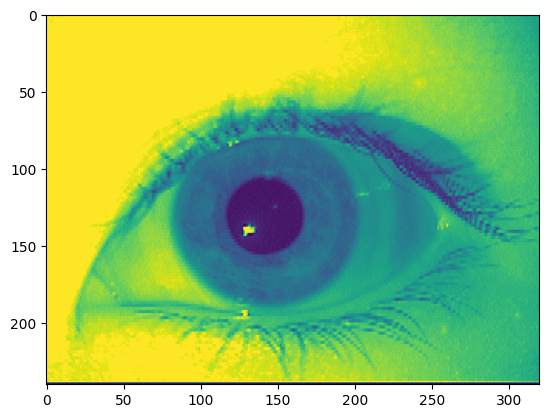

In [17]:
# permet d'afficher une des images de l'oeil gauche
plt.imshow(X_train[0][:,:,2])

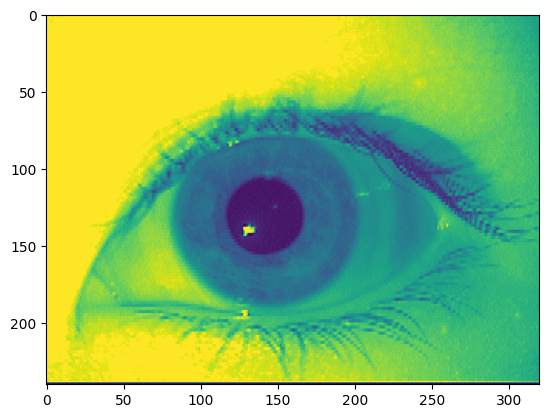

In [18]:
# permet d'afficher une des images de l'oeil droit
plt.imshow(X_train[0][:,:,2])

## Entrainement du modèle et affichage des performances pour oeil droit ou gauche (classifier)

In [51]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [52]:
NBCLASSES = 2
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in vgg.layers:
        layer.trainable = False

    # get the VGG output
    out = vgg.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model

classifier = create_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0   

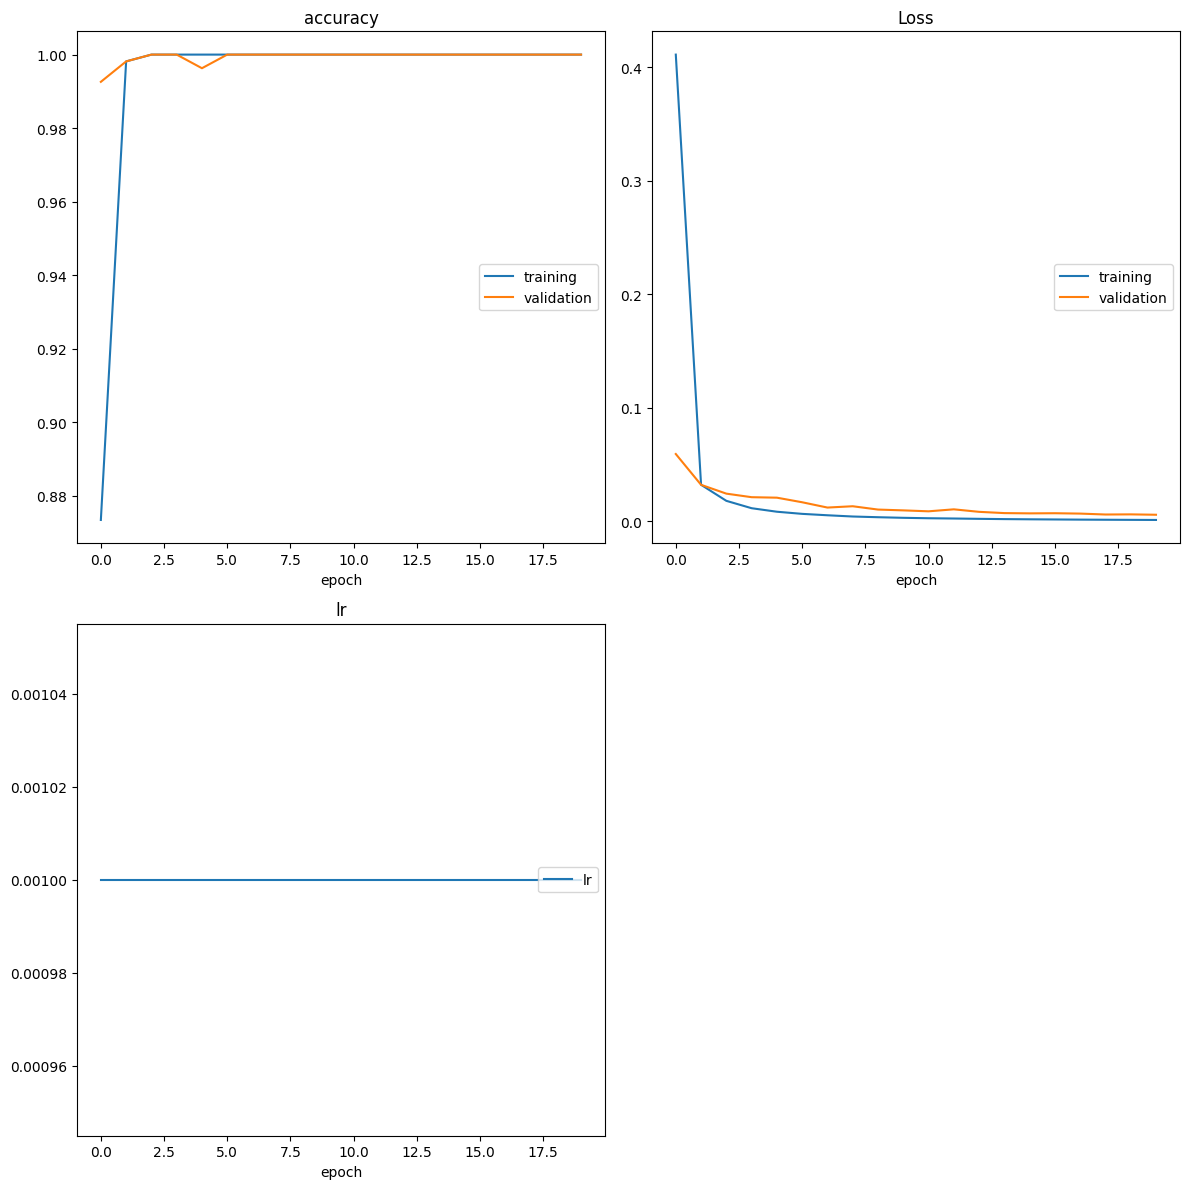

accuracy
	training         	 (min:    0.873, max:    1.000, cur:    1.000)
	validation       	 (min:    0.993, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.001, max:    0.411, cur:    0.001)
	validation       	 (min:    0.006, max:    0.059, cur:    0.006)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
54/54 [==============================] - 3s 56ms/step - loss: 9.6546e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000 - lr: 0.0010


In [53]:
hist = classifier.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 20, validation_data=(np.array(X_valid), np.array(y_valid_enc)),callbacks=[rlrop,early,PlotLossesKeras()])

In [62]:
# Données de test

y_test_pred = [np.argmax(v) for v in classifier.predict(np.array(X_test))]  # Prédictions du modèle

17/17 [==============================] - 1s 33ms/step


In [79]:
# Transformer y_test_enc en list pour le passage dans la matrice de confusion
y_test_enc_list = [1 if label[0] == 0.0 else 0 for label in y_test_enc]

# Vérifiez la structure de y_test_enc_list
y_test_enc_list

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,


Matrice de confusion :
[[269   0]
 [  0 270]]
Précision : 1.00
Rappel : 1.00
Score F1 : 1.00
Exactitude : 1.00


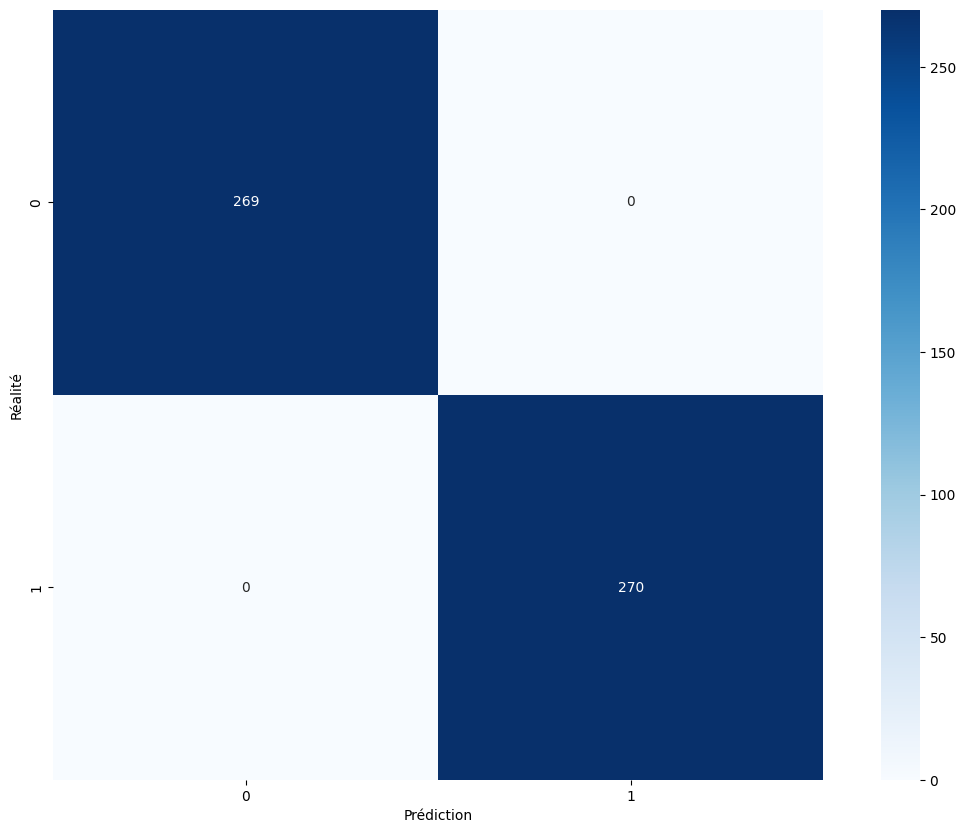

In [80]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_test_enc_list), np.array(y_test_pred))

# # Calcul des mesures de performance
accuracy = accuracy_score(y_test_enc_list, y_test_pred)
precision = precision_score(y_test_enc_list, y_test_pred,average='macro')
recall = recall_score(y_test_enc_list, y_test_pred,average='macro')
f1 = f1_score(y_test_enc_list, y_test_pred,average='macro')

print("Matrice de confusion :")
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

## Sauvegarde des modèles

In [77]:
classifier.save('models/classifier')